# Forest Cover Type Prediction
#### Team: Clear-Cut Solution: Kevin Martin, Yang Jing, Justine Schabel

TODO: Introduce the project 

## Initial Setup
#### Import Required Libraries

In [1]:
#surpress warning messages
import warnings
warnings.filterwarnings("ignore")

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

# Feature Engineering was written by the team 
import feature_engineering as fe
# Models was written by the team 
import models 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix

# So we can reload packages without restarting the kernel
import importlib



In [2]:
# If you update the feature_engineering package, run this line so it updates without needing to restart the kernel
importlib.reload(fe)

<module 'feature_engineering' from 'C:\\Users\\yjing\\Desktop\\MIDS\\W207\\Final Project\\mids-w207-final-project\\feature_engineering.py'>

#### Load Data

In [3]:
# Read in training data 
train_df = pd.read_csv("data/train.csv")

# Read in training data 
test_data = pd.read_csv("data/test.csv")
# Preserve testing df ID for submission purpose
test_df_ID = test_data["Id"]

#make a copy for testing subsets
test_data1 = test_data.copy() 

## Feature Engineering 
The following transformations were made in the function below. 

#### Transform Hillshade
Now we'll normalize the "Hillsdale" variables by dividing them by 255. The hillshade variables contain index of shades with a value between 0 and 255. 

#### Create new soil types
Now we'll create additional features to magnify the differences betweeen cover type1 and 2, and covery type3 and 6.

#### Combine soil types 

#### Drop rare or non-existant soil types 
Now we'll drop soil types that don't exist in the training set. Then we will combine soil types 35, 38, 39 and 40 because they have a very similar distribution. 

#### Create new features based on soil type descriptions 
TODO: Explain how we split up soil descriptions into different features to account for overlap.

#### Transform Aspect
TODO: Explain aspect problem and solution

#### Log transformations
Per EDA, we noticed the distribution of the "distance" related variables are skewed. Now we'll log transform the features related to the distances to make the distribution smoother, and thus decrease the variances of the predictions.

#### Add polynomial features
Per EDA, Elevation is a numerical variable and there is a clearer distinciton in Elevation among the dependenet variable, cover type. To imporve the signal, we sqaured Elevation. 

#### Drop irrelevant or problematic features
- We'll drop "Id" because it does not provide any meaning in the classifications.
- We'll drop "Hillshade_9am" because it has a high correlation with "Aspect" and "Hillshade_3pm".
- We'll also drop "Vertical_Distance_To_Hydrology" because it does not show much distinction among the "Cover Types" and has a very skewed distribution, with negative values in some cases. The variable offers little insight and there might be data issues in this variable. 


In [4]:
#subset trainning data into subsets to improve model accurracy with cover type 1&2, and 3&6.
train_df, train_df_12, train_df_36 = fe.subset_data(train_df)

In [5]:
def manipulate_data(data):
    """ 
    This function applys transformations on the input data set
    
    Parameters: 
        data (dataframe): n_examples x m_features (int64) dataframe 
    """
    data = fe.scale_hillside(data)
    
    
    # Soil Combination Two (based on descriptions)
    # data = fe.set_soil_type_by_attributes(data)
    
    data = fe.transform_aspect(data)
    
    features_to_log = ['Horizontal_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']
    data = fe.log_features(data, features_to_log)
    
    features_to_square = ["Elevation"]
    data = fe.add_polynomial_features(data, features_to_square)

    # These are already being dropped by now? 
    features_to_drop = ["Id","Hillshade_9am","Vertical_Distance_To_Hydrology"]
    data = fe.drop_features(data, features_to_drop)
    
    return data

train_df = manipulate_data(train_df)
train_df_12 = manipulate_data(train_df_12)
train_df_36 = manipulate_data(train_df_36)

In [6]:
def manipulate_ct12(data):
    """ 
    This function applys additional transformations on the input data set for cover type 1 and 2
    
    Parameters: 
        data (dataframe): n_examples x m_features (int64) dataframe 
    """
        
    # Soil Combination One (based on distributions)
    data = fe.combine_environment_features_ct12(data)
    data = fe.drop_unseen_soil_types(data)  
    data = fe.combine_soil_types(data)
      
    
    # Soil Combination Two (based on descriptions)
    # data = fe.set_soil_type_by_attributes(data)
    
    return data

train_df_12 = manipulate_ct12(train_df_12)


In [7]:
def manipulate_ct36(data):
    """ 
    This function applys additional transformations on the input data set for cover type 1 and 2
    
    Parameters: 
        data (dataframe): n_examples x m_features (int64) dataframe 
    """
        
    # Soil Combination One (based on distributions)
    data = fe.combine_environment_features_ct36(data)
    data = fe.drop_unseen_soil_types(data)  
    data = fe.combine_soil_types(data)
      
    
    # Soil Combination Two (based on descriptions)
    # data = fe.set_soil_type_by_attributes(data)
    
    return data

train_df_36 = manipulate_ct36(train_df_36)

#### Examine transformed data

In [8]:
train_df.describe()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,ap_ew,ap_ns,Elevation_squared
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,1.512000e+04
mean,2749.322553,16.501587,4.645584,7.124224,0.858689,0.529773,7.058263,0.237897,0.033003,0.419907,...,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,16.000000,0.226527,0.146622,7.733218e+06
std,417.678187,8.453927,1.805867,0.875852,0.089419,0.179981,0.776280,0.425810,0.178649,0.493560,...,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,12.972927,0.676366,0.685404,2.315859e+06
min,1863.000000,0.000000,0.000000,0.000000,0.388235,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,-1.000000,-1.000000,3.470769e+06
25%,2376.000000,10.000000,4.219508,6.639876,0.811765,0.415686,6.594413,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,-0.390731,-0.500000,5.645376e+06
50%,2752.000000,15.000000,5.198497,7.183112,0.874510,0.541176,7.136483,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.406737,0.275637,7.573504e+06
75%,3104.000000,22.000000,5.802118,7.727976,0.921569,0.654902,7.595513,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,0.866025,0.809017,9.634816e+06
max,3849.000000,52.000000,7.203406,8.837971,0.996078,0.972549,8.852808,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,1.000000,1.000000,1.481480e+07


Now that the data is transformed, we can also visualize the new aspect features. 

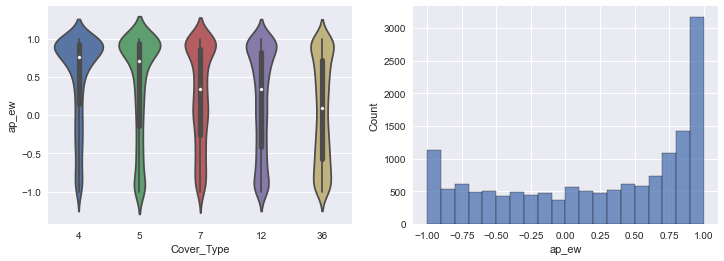

In [9]:
# Visualize cover type VS the cosine of Aspect degerees
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
sns.violinplot(x=train_df['Cover_Type'],y=train_df['ap_ew'],ax=ax1)
sns.histplot(train_df['ap_ew'],ax=ax2)
plt.show()

After the feature transformation, we see improved distinction in median values, espeically for cover type 6, where the median is notably higher than that of other cover types and the distribution is concentrated around the median.

#### Split data into train/dev

Then, we split the training data into a training data set (80%) and development data set (20%). We will also have a large, separate test data set. 

In [10]:
train_data, train_labels, dev_data, dev_labels = fe.split_data(train_df)
train_data12, train_labels12, dev_data12, dev_labels12  = fe.split_data(train_df_12)
train_data36, train_labels36, dev_data36, dev_labels36  = fe.split_data(train_df_36)

#### Scale the data to have a mean of 0 and a variance of 1.

In [11]:
standardize_features = ['Elevation','Slope', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points','Elevation_squared']
train_data, train_scaler = fe.scale_training_data(standardize_features, train_data, scaler_type="standard")
dev_data = fe.scale_non_training_data(standardize_features, dev_data, train_scaler)

#generate scaling models for separate subsets 
train_data12, train_12_scaler = fe.scale_training_data(standardize_features, train_data12, scaler_type="standard")
train_data36, train_36_scaler = fe.scale_training_data(standardize_features, train_data36, scaler_type="standard")

dev_data12 = fe.scale_non_training_data(standardize_features, dev_data12, train_12_scaler)
dev_data36 = fe.scale_non_training_data(standardize_features, dev_data36, train_36_scaler)


#### Explore and confirm the shape of the data

In [12]:
print("Training data shape: {0} Training labels shape: {1}\n".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data.shape, dev_labels.shape))

Training data shape: (12096, 54) Training labels shape: (12096,)

Dev data shape: (3024, 54) Dev labels shape: (3024,)



## Models

#### Random Forest

Random Forest Performance for 100 trees: 0.8776455026455027
Mean Squared Error:  51.714285714285715


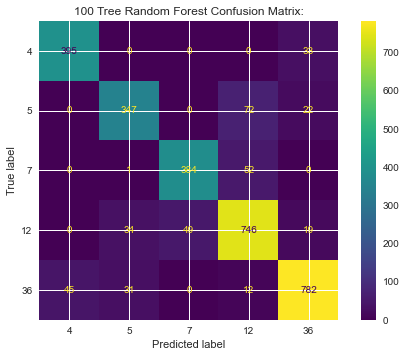

In [30]:
# num_trees_list = [1,3,5,10,100]
num_trees_list = [100]
random_forest_models = []
random_forest_results = {}
for num_trees in num_trees_list:
    score, probabilities, random_forest_model = models.random_forest(num_trees, train_data, train_labels, dev_data, dev_labels)
    random_forest_results[score] = probabilities
    random_forest_models.append(random_forest_model)

#### K-Nearest Neighbors

KNN 1 neighbors : accuracy = 0.9156746031746031
Mean Squared Error:  37.98048941798942


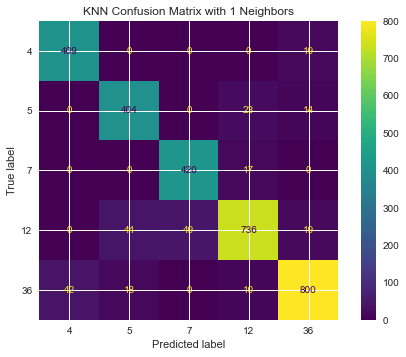

In [31]:
# neighbor_list = [1,2,4, 7, 10]
neighbor_list = [1]
knn_models = []
knn_results = {}
for neighbor in neighbor_list:
    score, probabilities, knn_model = models.k_nearest_neighbors(neighbor,train_data, train_labels, dev_data, dev_labels)
    knn_results[score] = probabilities
    knn_models.append(knn_model)
    

#### Multi-Layer Perceptron

MLP accuracy =  0.9315476190476191
Mean Squared Error:  29.15443121693122


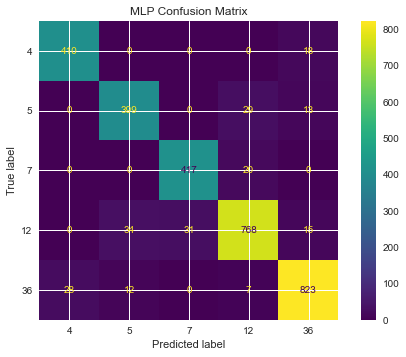

In [15]:
mlp_results = {}
score, probabilities,mlp_model = models.multi_layer_perceptron(train_data, train_labels, dev_data, dev_labels)
mlp_results[score] = probabilities 

#### Generate Subset test df for testing results

#### Apply the same transformations

In [16]:
test_data = manipulate_data(test_data)
test_data = fe.scale_non_training_data(standardize_features, test_data, train_scaler)

In [17]:
#generate subset df for spearte testing.
y_pred = mlp_model.predict(test_data)
def gen_subset_test(y_pred):
    result = pd.DataFrame.from_dict(dict(zip(test_df_ID.to_list(),y_pred)), orient='index', columns=["Cover_Type"])
    type12_id = result[result.Cover_Type==12].index.to_list()
    type36_id = result[result.Cover_Type==36].index.to_list()
    test_12 = test_data1[test_data1.Id.isin(type12_id)]
    test_36 = test_data1[test_data1.Id.isin(type36_id)]
    test_12_id = test_12.Id
    test_36_id = test_36.Id
    return test_12, test_36, result, test_12_id, test_36_id
test_12, test_36, result, test_12_id, test_36_id = gen_subset_test(y_pred)

In [18]:
#transofrm and scale the subset data with the respective scalers
test_12 = manipulate_data(test_12)
test_36 = manipulate_data(test_36)
test_12 = fe.scale_non_training_data(standardize_features, test_12, train_12_scaler)
test_36 = fe.scale_non_training_data(standardize_features, test_36, train_36_scaler)

#additional feature engineering for each subset
test_12 = manipulate_ct12(test_12)
test_36 = manipulate_ct36(test_36)

CT 1_2 accuracy =  0.7974537037037037
Mean Squared Error:  0.2025462962962963


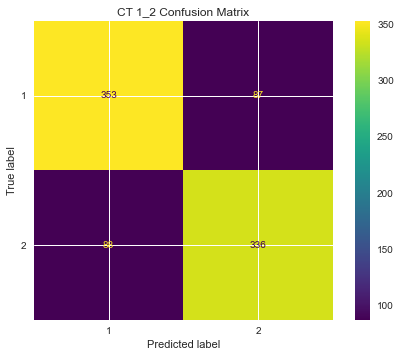

In [19]:
#run the mlp model for subset of cover type 1 and 2
def subset_12():
    """This funciton trains a MLP model specifically on cover type 1 and 2 datasets"""
    model = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(200,), random_state=0, max_iter=200) 
    model.fit(train_data12, train_labels12) 
    predictions = model.predict(dev_data12)
    ypred12 = model.predict(test_12)
    res12 = pd.DataFrame.from_dict(dict(zip(test_12_id.to_list(),ypred12)), orient='index', columns=["Cover_Type"])
    score = model.score(dev_data12, dev_labels12)
    probabilities = model.predict_proba(dev_data12)
    plot_confusion_matrix(model, dev_data12, dev_labels12, values_format = "d")
    plt.title("CT 1_2 Confusion Matrix")
    plt.plot()
    print("CT 1_2 accuracy = ",score)
    mse_nn = mean_squared_error(dev_labels12, predictions)
    print("Mean Squared Error: ", mse_nn)
           
    return score, probabilities, res12
score12, prob12, res12 = subset_12()

MLP accuracy =  0.8773148148148148
Mean Squared Error:  1.1041666666666667


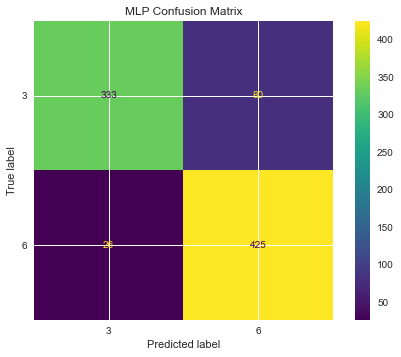

In [20]:
def subset_36():
    """This funciton trains a MLP model specifically on cover type 3 and 6 datasets"""
    model = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(200,), random_state=0, max_iter=200) 
    model.fit(train_data36, train_labels36) 
    predictions = model.predict(dev_data36)
    ypred36 = model.predict(test_36)
    res36 = pd.DataFrame.from_dict(dict(zip(test_36_id.to_list(),ypred36)), orient='index', columns=["Cover_Type"])
    score = model.score(dev_data36, dev_labels36)
    probabilities = model.predict_proba(dev_data36)
    plot_confusion_matrix(model, dev_data36, dev_labels36, values_format = "d")
    plt.title("MLP Confusion Matrix")
    plt.plot()
    print("MLP accuracy = ",score)
    mse_nn = mean_squared_error(dev_labels36, predictions)
    print("Mean Squared Error: ", mse_nn)
           
    return score, probabilities, res36, ypred36
score36, prob36, res36, ypred36 = subset_36()

#### Logistic Regression

In [21]:
models.logistic_regression(train_data, train_labels, dev_data, dev_labels)

Logistic Regression accuracy =  0.8204365079365079


#### Neural Network 

In [22]:
# models.neural_network(train_data, train_labels, dev_data, dev_labels)

#### Ensemble
Here we will combine the three best performing models and implement a "voting" system to try to improve accuracy.

In [23]:
predicted_classes, new_predictions = models.ensemble(mlp_results,knn_results,random_forest_results, dev_labels)
mse_ensemble = mean_squared_error(dev_labels, new_predictions)
accuracy = accuracy_score(dev_labels, new_predictions)
print("Mean Squared Error: ", mse_ensemble)
print("Accuracy: ", accuracy)

Models disagreed on 2979/3024 dev examples.
Mean Squared Error:  309.1332671957672
Accuracy:  0.0033068783068783067


#### Examine and Compare Histograms of Predictions

(array([447., 419.,   0., 431.,   0., 881., 846.]),
 array([0.        , 0.57142857, 1.14285714, 1.71428571, 2.28571429,
        2.85714286, 3.42857143, 4.        ]),
 <BarContainer object of 7 artists>)

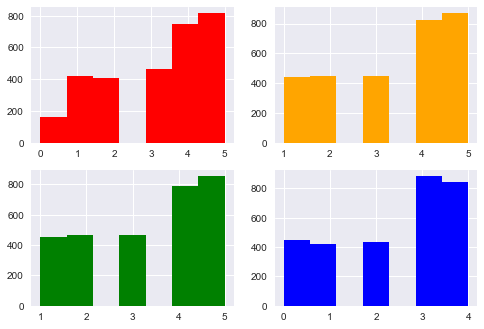

In [24]:
fig, axes = plt.subplots(2,2)
# Ensemble
axes[0,0].hist(new_predictions, bins=7,color = 'red') 
# MLP
axes[0,1].hist(predicted_classes[:,0], bins=7, color = 'orange') 
# KNN
axes[1,0].hist(predicted_classes[:,1], bins=7, color = 'green') 
# Random Forest
axes[1,1].hist(predicted_classes[:,2], bins=7, color = 'blue') 

### Test Results

In [25]:
#generate predictions for test data
# random_forest_predictions = random_forest_models[-1].predict(test_data)
# knn_predictions = knn_models[0].predict(test_data)
# mlp_predictions = mlp_model.predict(test_data)
final_file = result[result.Cover_Type.isin([4,5,7])].append(res36).append(res12)

#### Generate Submission File

In [29]:
def gen_submission(file):
#     result = pd.DataFrame.from_dict(dict(zip(test_df_ID.to_list(),y_pred)), orient='index', columns=["Cover_Type"])
    file.to_csv(f"submissions/cobsolidated_submission.csv",index_label="Id")

# gen_submission(random_forest_predictions, model="RandomForest")
# gen_submission(knn_predictions, model="KNN")
gen_submission(final_file)

### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [27]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear_cut_solution.ipynb --to="python" --output="backups/clear_cut_solution"
!jupyter nbconvert clear_cut_solution.ipynb --to markdown --output="backups/clear_cut_solution"

# Also archiving this bad boy
!jupyter nbconvert clear_cut_solution.ipynb --to html --output="backups/clear_cut_solution"

[NbConvertApp] Converting notebook clear_cut_solution.ipynb to python
[NbConvertApp] Writing 14818 bytes to backups\clear_cut_solution.py
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to markdown
[NbConvertApp] Support files will be in backups/clear_cut_solution_files\
[NbConvertApp] Making directory backups/clear_cut_solution_files\backups
[NbConvertApp] Making directory backups/clear_cut_solution_files\backups
[NbConvertApp] Making directory backups/clear_cut_solution_files\backups
[NbConvertApp] Making directory backups/clear_cut_solution_files\backups
[NbConvertApp] Making directory backups/clear_cut_solution_files\backups
[NbConvertApp] Making directory backups/clear_cut_solution_files\backups
[NbConvertApp] Making directory backups/clear_cut_solution_files\backups
[NbConvertApp] Making directory backups/clear_cut_solution_files\backups
[NbConvertApp] Making directory backups/clear_cut_solution_files\backups
[NbConvertApp] Making directory backups/clear_cut_solution_